In [1]:
import numpy as np
import pandas as pd
import pandasql as psql
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
from scipy.spatial.distance import cdist

import gc

seed=15

# Lectura de los datos y embeddings

In [2]:
%%time
df_train_orig = pd.read_parquet('../data/df_filt_train_100_100.zip')
df_train_orig.shape

Wall time: 1.08 s


(8556951, 3)

In [3]:
df_train_orig.head(10)

,movie_id,user_id,rating
10930635,2128,2000429,4
46725692,8387,382224,3
27446119,5075,1617455,4
80443653,14491,143113,3
85964770,15246,768876,5
80408073,14484,2261348,4
24386603,4577,2451473,3
88071659,15657,2364018,3
91429355,16265,2110908,5
11491757,2186,662478,3


In [4]:
%%time
df_val_orig = pd.read_parquet('../data/df_filt_val_100_100.zip')
df_val_orig.shape

Wall time: 425 ms


(6417714, 3)

In [5]:
df_val_orig.head(10)

,movie_id,user_id,rating
3884480,752,1551333,5
83843802,14961,2009898,4
24357576,4577,168479,5
49181371,8846,1908261,4
53710780,9757,659928,3
85028019,15116,2339843,4
10697378,2108,631598,5
49339509,8880,1712681,4
85932015,15234,756211,2
13763540,2617,2030407,3


Leemos las traducciones de los IDs para los embeddings

In [6]:
translate_movies = pd.read_csv('translate_movies_tts_100_100.csv')
translate_movies.head()

,movie_id,movie_id_orig
0,3588,2128
1,6336,8387
2,4885,5075
3,1987,14491
4,2323,15246


In [7]:
translate_users = pd.read_csv('translate_users_tts_100_100.csv')
translate_users.head()

,user_id,user_id_orig
0,31206,2000429
1,55088,382224
2,19393,1617455
3,13510,143113
4,67063,768876


In [8]:
query_df_train_translate = """
SELECT b.movie_id
    , c.user_id
    , a.rating
    , a.movie_id as movie_id_orig
    , a.user_id as user_id_orig

from df_train_orig as a

left join translate_movies as b
    on a.movie_id = b.movie_id_orig

left join translate_users as c
    on a.user_id = c.user_id_orig

"""

In [9]:
%%time
df_train = psql.sqldf(query_df_train_translate, locals())
df_train.head()

Wall time: 2min 25s


,movie_id,user_id,rating,movie_id_orig,user_id_orig
0,3588,31206,4,2128,2000429
1,6336,55088,3,8387,382224
2,4885,19393,4,5075,1617455
3,1987,13510,3,14491,143113
4,2323,67063,5,15246,768876


In [10]:
query_df_val_translate = """
SELECT b.movie_id
    , c.user_id
    , a.rating
    , a.movie_id as movie_id_orig
    , a.user_id as user_id_orig

from df_val_orig as a

left join translate_movies as b
    on a.movie_id = b.movie_id_orig

left join translate_users as c
    on a.user_id = c.user_id_orig

"""

In [11]:
%%time
df_val = psql.sqldf(query_df_val_translate, locals())
df_val.head()

Wall time: 1min 42s


,movie_id,user_id,rating,movie_id_orig,user_id_orig
0,5944,17288,5,752,1551333
1,2193,31509,4,14961,2009898
2,4673,21434,5,4577,168479
3,6554,28375,4,8846,1908261
4,6937,63695,3,9757,659928


In [12]:
df_val.head(20)

,movie_id,user_id,rating,movie_id_orig,user_id_orig
0,5944,17288,5,752,1551333
1,2193,31509,4,14961,2009898
2,4673,21434,5,4577,168479
3,6554,28375,4,8846,1908261
4,6937,63695,3,9757,659928
5,2260,41654,4,15116,2339843
6,3578,62848,5,2108,631598
7,6567,22333,4,8880,1712681
8,2316,66684,2,15234,756211
9,3808,32107,3,2617,2030407


In [13]:
emb_dim = 10
lr_str = 20
niter_str = "10k"

modelo = "embeddings/"
tamanyo = f"_dim{emb_dim}_{lr_str}_{niter_str}"

# Cargar embeddings
print(f'./{modelo}user_embeddings{tamanyo}.npy')
print(f'./{modelo}movie_embeddings{tamanyo}.npy')
user_embeddings = np.load(f'./{modelo}user_embeddings{tamanyo}.npy')
movie_embeddings = np.load(f'./{modelo}movie_embeddings{tamanyo}.npy')

./embeddings/user_embeddings_dim10_20_10k.npy
./embeddings/movie_embeddings_dim10_20_10k.npy


# Funciones de predicción

In [14]:
def predict_with_k_nearest_movies(target_movie_id, user_id, ks=[10], movie_embeddings=movie_embeddings, df_input=df_train):
    """
    Predicts the rating of a target movie for a given user based on k-nearest movies rated by the user.

    Args:
        target_movie_id (int): The ID of the target movie for which we want to predict the rating.
        user_id (int): The ID of the user for whom we are predicting the rating.
        ks (list of int): List of values for k (number of nearest neighbors) to use for prediction.
        movie_embeddings (np.array): Array of movie embeddings where the index corresponds to movie_id.
        df_input (pd.DataFrame): DataFrame containing columns ['user_id', 'movie_id', 'rating'] with user ratings.
        bool_max (bool): If True, also computes the prediction using all movies rated by the user.

    Returns:
        dict: A dictionary with keys as values of k (and 'max' if bool_max is True) and values as the predicted ratings.
    """

    prediction = {}

    # Filtrar las películas calificadas por el usuario, excluyendo la película objetivo
    df_filt = df_input[(df_input['user_id'] == user_id) & (df_input['movie_id'] != target_movie_id)][['movie_id', 'rating']]
    movies_ids = df_filt['movie_id'].values

    # Calcular las distancias entre la película objetivo y las películas calificadas por el usuario
    distances = cdist(movie_embeddings[movies_ids], movie_embeddings[target_movie_id].reshape(1, -1)).flatten()
    distances_argsort = np.argsort(distances)

    # Precalcular las inversas de las distancias para los vecinos más cercanos
    inverse_distances = 1 / distances[distances_argsort]

    for k in ks:

        nearest_inverse_distances = inverse_distances[:k]
        nearest_ratings = df_filt.iloc[distances_argsort[:k], 1].values

        # Predicción ponderada por la inversa de las distancias
        prediction[k] = np.dot(nearest_inverse_distances, nearest_ratings) / nearest_inverse_distances.sum()

    return prediction


In [15]:
def predict_with_k_nearest_users(target_user_id, movie_id, ks=[10], user_embeddings=user_embeddings, df_input=df_train):
    """
    Predicts the rating of a target movie for a given user based on k-nearest users who rated the movie.

    Args:
        target_user_id (int): The ID of the target user for whom we want to predict the rating.
        movie_id (int): The ID of the movie for which we are predicting the rating.
        ks (list of int): List of values for k (number of nearest neighbors) to use for prediction.
        user_embeddings (np.array): Array of user embeddings where the index corresponds to user_id.
        df_input (pd.DataFrame): DataFrame containing columns ['user_id', 'movie_id', 'rating'] with user ratings.
        bool_max (bool): If True, also computes the prediction using all users who rated the movie.

    Returns:
        dict: A dictionary with keys as values of k (and 'max' if bool_max is True) and values as the predicted ratings.
    """

    prediction = {}

    # Filtrar los usuarios que han calificado la película, excluyendo al usuario objetivo
    df_filt = df_input[(df_input['movie_id'] == movie_id) & (df_input['user_id'] != target_user_id)][['user_id', 'rating']]
    users_ids = df_filt['user_id'].values

    # Calcular las distancias entre el usuario objetivo y los usuarios que han calificado la película
    distances = cdist(user_embeddings[users_ids], user_embeddings[target_user_id].reshape(1, -1)).flatten()
    distances_argsort = np.argsort(distances)

    # Precalcular las inversas de las distancias para los vecinos más cercanos
    inverse_distances = 1 / distances[distances_argsort]

    for k in ks:

        nearest_inverse_distances = inverse_distances[:k]
        nearest_ratings = df_filt.iloc[distances_argsort[:k], 1].values

        # Predicción ponderada por la inversa de las distancias
        prediction[k] = np.dot(nearest_inverse_distances, nearest_ratings) / nearest_inverse_distances.sum()

    return prediction


In [16]:
def predict_dot_product(user_id, movie_id, user_embeddings=user_embeddings, movie_embeddings=movie_embeddings):
    return np.dot(user_embeddings[user_id],movie_embeddings[movie_id])

Modificaciones para optimizar las puntuaciones

In [17]:
def create_index(df_input, var):
    """
    Crea un diccionario que mapea cada user_id a los índices de las películas que ha visto.

    Args:
        df_input (pd.DataFrame): DataFrame con columnas ['user_id', 'movie_id', 'rating'].

    Returns:
        dict: Diccionario con user_id como clave y lista de índices como valor.
    """
    indices = {}
    for var_id, group in df_input.groupby(var):
        indices[var_id] = group.index.tolist()
    return indices


In [18]:
%%time
user_index = create_index(df_train,"user_id")

Wall time: 4.78 s


In [19]:
%%time
movie_index = create_index(df_train,"movie_id")

Wall time: 2.44 s


In [20]:
def predict_with_k_nearest_movies_dict(target_movie_id, user_id, ks=[10], movie_embeddings=movie_embeddings, df_input=df_train, user_index=user_index):
    """
    Predice la calificación de una película objetivo para un usuario dado basándose en las k-nearest películas calificadas por el usuario.

    Args:
        target_movie_id (int): ID de la película objetivo para la que queremos predecir la calificación.
        user_id (int): ID del usuario para quien estamos prediciendo la calificación.
        ks (list of int): Lista de valores para k (número de vecinos más cercanos) a usar para la predicción.
        movie_embeddings (np.array): Array de embeddings de películas donde el índice corresponde a movie_id.
        df_input (pd.DataFrame): DataFrame con columnas ['user_id', 'movie_id', 'rating'] con calificaciones de usuarios.
        user_index (dict): Diccionario con user_id como clave y lista de índices de las películas que ha visto como valor.
        bool_max (bool): Si es True, también calcula la predicción usando todas las películas calificadas por el usuario.

    Returns:
        dict: Un diccionario con las claves como valores de k (y 'max' si bool_max es True) y los valores como las calificaciones predichas.
    """
    prediction = {}

    # Filtrar las películas calificadas por el usuario (usando los índices en lugar de aplicar condiciones)
    df_filt = df_input.iloc[user_index[user_id]][['movie_id', 'rating']]
    movies_ids = df_filt['movie_id'].values

    # Calcular las distancias entre la película objetivo y las películas calificadas por el usuario
    distances = cdist(movie_embeddings[movies_ids], movie_embeddings[target_movie_id].reshape(1, -1)).flatten()
    distances_argsort = np.argsort(distances)

    # Precalcular las inversas de las distancias para los vecinos más cercanos
    inverse_distances = 1 / distances[distances_argsort]

    for k in ks:
        nearest_inverse_distances = inverse_distances[:k]
        nearest_ratings = df_filt.iloc[distances_argsort[:k], 1].values

        # Predicción ponderada por la inversa de las distancias
        prediction[k] = np.dot(nearest_inverse_distances, nearest_ratings) / nearest_inverse_distances.sum()

    return prediction


In [21]:
def predict_with_k_nearest_users_dict(target_user_id, movie_id, ks=[10], user_embeddings=user_embeddings, df_input=df_train, movie_index=movie_index):
    """
    Predice la calificación de una película objetivo para un usuario dado basándose en los k usuarios más cercanos
    que han calificado la película.

    Args:
        target_user_id (int): ID del usuario objetivo para el cual queremos predecir la calificación.
        movie_id (int): ID de la película para la cual estamos prediciendo la calificación.
        ks (list of int): Lista de valores para k (número de vecinos más cercanos) a usar para la predicción.
        user_embeddings (np.array): Array de embeddings de usuarios donde el índice corresponde a user_id.
        df_input (pd.DataFrame): DataFrame que contiene las columnas ['user_id', 'movie_id', 'rating'] con calificaciones de usuarios.
        movie_index (dict): Diccionario con movie_id como clave y lista de índices de los usuarios que han calificado esa película como valor.
        bool_max (bool): Si es True, también calcula la predicción usando todos los usuarios que han calificado la película.

    Returns:
        dict: Un diccionario con las claves como valores de k (y 'max' si bool_max es True) y los valores como las calificaciones predichas.
    """
    prediction = {}

    # Filtrar los usuarios que han calificado la película (usando los índices en lugar de aplicar condiciones)
    df_filt = df_input.iloc[movie_index[movie_id]][['user_id', 'rating']]
    users_ids = df_filt['user_id'].values

    # Calcular las distancias entre el usuario objetivo y los usuarios que han calificado la película
    distances = cdist(user_embeddings[users_ids], user_embeddings[target_user_id].reshape(1, -1)).flatten()
    distances_argsort = np.argsort(distances)

    # Precalcular las inversas de las distancias para los vecinos más cercanos
    inverse_distances = 1 / distances[distances_argsort]

    for k in ks:
        nearest_inverse_distances = inverse_distances[:k]
        nearest_ratings = df_filt.iloc[distances_argsort[:k], 1].values

        # Predicción ponderada por la inversa de las distancias
        prediction[k] = np.dot(nearest_inverse_distances, nearest_ratings) / nearest_inverse_distances.sum()

    return prediction


In [5]:
ks = [1,2,3,4,5,6,7,8,9,10,15,20]

In [23]:
%%time
# CUIDADO QUE ESTE TARDA

gc.collect()

t0 = time()
df_val['prediction_movies'] = df_val.apply(lambda row: predict_with_k_nearest_movies_dict(row['movie_id'], row['user_id'], ks=ks), axis=1)
t1 = time()
print(f"predict_with_k_nearest_movies_dict: {(t1-t0)/60} mins")

gc.collect()

t0 = time()
df_val['prediction_users']  = df_val.apply(lambda row: predict_with_k_nearest_users_dict(row['user_id'], row['movie_id'], ks=ks), axis=1)
t1 = time()
print(f"predict_with_k_nearest_users_dict:  {(t1-t0)/60} mins")

gc.collect()

t0 = time()
df_val['prediction_dot'] = df_val.apply(lambda row: predict_dot_product(row['user_id'], row['movie_id']), axis=1)
t1 = time()
print(f"df_predict_dot_product: {(t1-t0)/60} mins")

gc.collect()

predict_with_k_nearest_movies_dict: 320.8590161085129 mins
predict_with_k_nearest_users_dict:  719.4631072203318 mins
df_predict_dot_product: 4.065218742688497 mins
Wall time: 17h 24min 36s


0

In [10]:
%%time
# Calculo de las metricas

metricas_movies1, metricas_users1, metricas_movies2, metricas_users2, metricas_movies3, metricas_users3 = {},{},{},{},{},{}


for k in ks:
    
#     t0 = time()
    print(f"ITERACION K={k}")
#     df_val[f'prediction_movies_{k}'] = df_val['prediction_movies'].apply(lambda x: x[k])
#     df_val[f'prediction_users_{k}'] = df_val['prediction_users'].apply(lambda x: x[k])
#     t1=time()
#     print(f"PUNTO 1.{k}: TIEMPO {t1-t0}")
    t0=time()
        
    metricas_movies1[k] = mean_absolute_error(y_true=df_val['rating'], y_pred=df_val[f'prediction_movies_{k}'])
    metricas_users1[k] = mean_absolute_error(y_true=df_val['rating'], y_pred=df_val[f'prediction_users_{k}'])
    
    t1=time()
    print(f"PUNTO 2.{k}: TIEMPO {t1-t0}")
    print(f"MAE movie.{k}: {metricas_movies1[k]}")
    print(f"MAE users.{k}: {metricas_users1[k]}")
    t0=time()
    
    metricas_movies2[k] = mean_squared_error(y_true=df_val['rating'], y_pred=df_val[f'prediction_movies_{k}'])
    metricas_users2[k] = mean_squared_error(y_true=df_val['rating'], y_pred=df_val[f'prediction_users_{k}'])
    
    t1=time()
    print(f"PUNTO 3.{k}: TIEMPO {t1-t0}")
    print(f"RMSE movie.{k}: {metricas_movies2[k]}")
    print(f"RMSE users.{k}: {metricas_users2[k]}")
    t0=time()
    
    metricas_movies3[k] = (df_val[f'prediction_movies_{k}'] - df_val['rating']).mean()
    metricas_users3[k] = (df_val[f'prediction_users_{k}'] - df_val['rating']).mean()
    
    t1=time()
    print(f"PUNTO 4.{k}: TIEMPO {t1-t0}")
    print(f"ME movie.{k}: {metricas_movies2[k]}")
    print(f"ME users.{k}: {metricas_users2[k]}")
    print()

metricas_dot1 = mean_absolute_error(y_true=df_val['rating'], y_pred=df_val['prediction_dot'])
metricas_dot2 = mean_squared_error(y_true=df_val['rating'], y_pred=df_val['prediction_dot'])
metricas_dot3 = (df_val[f'prediction_dot'] - df_val['rating']).mean()


ITERACION K=1
PUNTO 2.1: TIEMPO 0.15648579597473145
MAE movie.1: 0.8833450664831746
MAE users.1: 1.0431697330233165
PUNTO 3.1: TIEMPO 0.14061832427978516
RMSE movie.1: 1.5394581310416762
RMSE users.1: 1.9271954156885147
PUNTO 4.1: TIEMPO 0.07635021209716797
ME movie.1: 1.5394581310416762
ME users.1: 1.9271954156885147

ITERACION K=2
PUNTO 2.2: TIEMPO 0.17405986785888672
MAE movie.2: 0.8133848891904825
MAE users.2: 0.9420311034359213
PUNTO 3.2: TIEMPO 0.1484522819519043
RMSE movie.2: 1.1689311893180219
RMSE users.2: 1.4479100205433313
PUNTO 4.2: TIEMPO 0.07070112228393555
ME movie.2: 1.1689311893180219
ME users.2: 1.4479100205433313

ITERACION K=3
PUNTO 2.3: TIEMPO 0.13492918014526367
MAE movie.3: 0.7819715749812716
MAE users.3: 0.8979595089876867
PUNTO 3.3: TIEMPO 0.19249176979064941
RMSE movie.3: 1.0455621111419138
RMSE users.3: 1.287967821152455
PUNTO 4.3: TIEMPO 0.0643608570098877
ME movie.3: 1.0455621111419138
ME users.3: 1.287967821152455

ITERACION K=4
PUNTO 2.4: TIEMPO 0.1506876

In [6]:
metricas_dot1

0.725233809748046

In [7]:
metricas_movies1

{1: 0.8833450664831746,
 2: 0.8133848891904825,
 3: 0.7819715749812716,
 4: 0.7640011709532216,
 5: 0.7524265697605245,
 6: 0.7445274291138528,
 7: 0.7388056007308165,
 8: 0.7343795377789011,
 9: 0.730968888873601,
 10: 0.7282894636867523,
 15: 0.7206659183272901,
 20: 0.7174396286340842}

In [8]:
metricas_users1

{1: 1.0431697330233165,
 2: 0.9420311034359213,
 3: 0.8979595089876867,
 4: 0.8736453456961132,
 5: 0.857945901662714,
 6: 0.8474203907313627,
 7: 0.8397325346918078,
 8: 0.8339280294056365,
 9: 0.8294474984168245,
 10: 0.8258593284643818,
 15: 0.8153044146210296,
 20: 0.8102303533970784}

In [8]:
xmin = 0
xmax = max(ks)

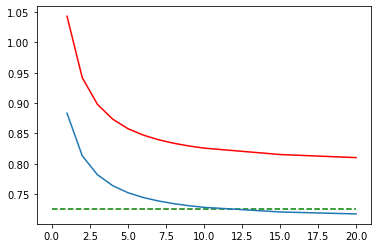

In [14]:
plt.hlines(metricas_dot1,xmin,xmax, colors='g', linestyles='dashed')

lists = sorted(metricas_movies1.items())
x, y = zip(*lists)
plt.plot(x, y)

lists = sorted(metricas_users1.items())
x2, y2 = zip(*lists)
plt.plot(x2, y2, color='r')

plt.show()

In [15]:
metricas_dot2

0.8586071130183134

In [16]:
# nos quedamos con k=6 (k=7 no mejora ni una centesima y cuesta mucha mas computacion)
metricas_movies2

{1: 1.2407490201655111,
 2: 1.081171211842982,
 3: 1.0225273155969545,
 4: 0.992063655989922,
 5: 0.9733405806616219,
 6: 0.9608016670854305,
 7: 0.9518402570950929,
 8: 0.9450003131302905,
 9: 0.9397558594211772,
 10: 0.9356412050705681,
 15: 0.9236461236492103,
 20: 0.918159729844081}

In [31]:
# Ordenar las claves
sorted_keys = sorted(metricas_movies2.keys())

# Lista para almacenar los resultados
result = []

# Calcular las diferencias y dividir
for i in range(1, len(sorted_keys)):
    key_diff = sorted_keys[i] - sorted_keys[i - 1]
    value_diff = metricas_movies2[sorted_keys[i]] - metricas_movies2[sorted_keys[i - 1]]
    result.append(value_diff / key_diff)
    print(f"{i:2d}: {value_diff / key_diff}")
    

 1: -0.1595778083225292
 2: -0.058643896246027394
 3: -0.030463659607032567
 4: -0.018723075328300087
 5: -0.012538913576191413
 6: -0.008961409990337565
 7: -0.006839943964802364
 8: -0.005244453709113306
 9: -0.004114654350609093
10: -0.002399016284271571
11: -0.0010972787610258549


In [38]:
# Ordenar las claves
sorted_keys = sorted(metricas_movies2.keys())

# Lista para almacenar los resultados
result = []

# Calcular las diferencias y dividir
for i in range(1, len(sorted_keys)):
    key_diff = sorted_keys[i] - sorted_keys[i-1]
    value_diff = (metricas_movies2[sorted_keys[i]] - metricas_movies2[sorted_keys[i-1]]) / metricas_movies2[sorted_keys[i-1]]
    result.append(value_diff / key_diff)
    print(f"{i:2d}: {value_diff / key_diff}")
    

 1: -0.12861409175341693
 2: -0.05424108189679048
 3: -0.02979251423640237
 4: -0.018872856812416367
 5: -0.012882349534495078
 6: -0.009327013365330428
 7: -0.007186020883038807
 8: -0.005549684625755499
 9: -0.004378429045543198
10: -0.0025640344517433174
11: -0.0011879861052094755


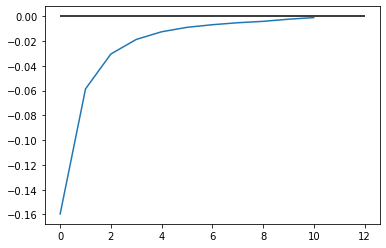

In [29]:
plt.hlines(0,0,len(sorted_keys), colors='k')

# Imprimir el resultado
plt.plot(result)
plt.show()

In [18]:
# nos quedamos con k=7 (k=8 no mejora ni una centesima y cuesta mucha mas computacion)
metricas_users2

{1: 1.3882346399973293,
 2: 1.2032913282091462,
 3: 1.1348866996984568,
 4: 1.0995038841969045,
 5: 1.0775051165819878,
 6: 1.0628933614622842,
 7: 1.0523609536327962,
 8: 1.044420861878539,
 9: 1.0383060953016827,
 10: 1.0334004728744568,
 15: 1.0187973151459822,
 20: 1.0116457163294368}

In [33]:
# Ordenar las claves
sorted_keys = sorted(metricas_users2.keys())

# Lista para almacenar los resultados
result = []

# Calcular las diferencias y dividir
for i in range(1, len(sorted_keys)):
    key_diff = sorted_keys[i] - sorted_keys[i - 1]
    value_diff = metricas_users2[sorted_keys[i]] - metricas_users2[sorted_keys[i - 1]]
    result.append(value_diff / key_diff)
    print(f"{i:2d}: {value_diff / key_diff}")
    

 1: -0.18494331178818313
 2: -0.0684046285106894
 3: -0.03538281550155231
 4: -0.021998767614916703
 5: -0.014611755119703584
 6: -0.010532407829487944
 7: -0.00794009175425714
 8: -0.00611476657685639
 9: -0.00490562242722592
10: -0.0029206315456949293
11: -0.0014303197633090737


In [37]:
for i in range(len(result)-1):
    result2 = result[i] / result[i+1]
    print(f"{i+1:2d}: {result[i] / result[i+1]}")

 1: 2.703666635062312
 2: 1.9332726223465275
 3: 1.608399894072261
 4: 1.5055527166104719
 5: 1.3873138370880922
 6: 1.326484397846022
 7: 1.2985110150090393
 8: 1.2464812911241987
 9: 1.679644402409098
10: 2.041943081970698


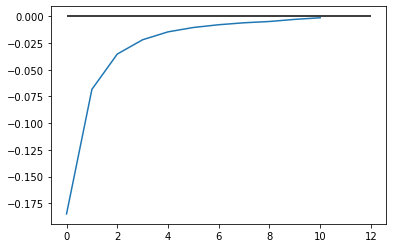

In [19]:
# Ordenar las claves
sorted_keys = sorted(metricas_users2.keys())

# Lista para almacenar los resultados
result = []

plt.hlines(0,0,len(sorted_keys), colors='k')

# Calcular las diferencias y dividir
for i in range(1, len(sorted_keys)):
    key_diff = sorted_keys[i] - sorted_keys[i - 1]
    value_diff = metricas_users2[sorted_keys[i]] - metricas_users2[sorted_keys[i - 1]]
    result.append(value_diff / key_diff)
    
# Imprimir el resultado
plt.plot(result)
plt.show()

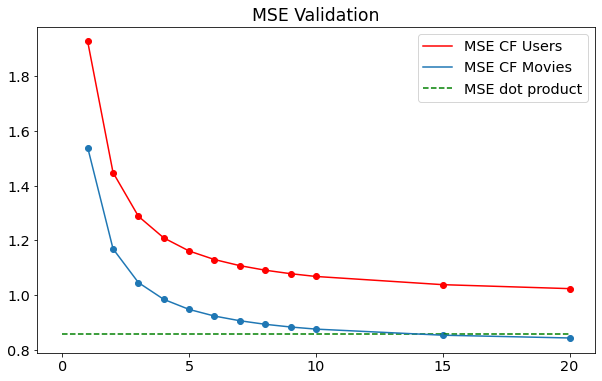

In [34]:
plt.figure(figsize=(10, 6))  # Ancho x Alto

lists = sorted(metricas_users2.items())
x, y = zip(*lists)
plt.plot(x, y, color='r')

lists = sorted(metricas_movies2.items())
x2, y2 = zip(*lists)
plt.plot(x2, y2)

plt.hlines(metricas_dot2,xmin,xmax, colors='g', linestyles='dashed')

plt.legend(labels=['MSE CF Users','MSE CF Movies', 'MSE dot product'],fontsize='x-large')

plt.scatter(x, y, color='r')
plt.scatter(x2, y2)

plt.xticks(np.arange(21,step=5),fontsize='x-large')
plt.yticks(np.arange(0.8,2,step=0.2),fontsize='x-large')

plt.title('MSE Validation',fontsize='xx-large')
plt.show()

In [21]:
metricas_dot3

-0.002925591783213818

In [22]:
metricas_movies3

{1: 0.009886074698872527,
 2: 0.009629412230213234,
 3: 0.009411375590825118,
 4: 0.009324191326319467,
 5: 0.009385936966329693,
 6: 0.009458504316338217,
 7: 0.009564836186623389,
 8: 0.009696205740233086,
 9: 0.009817807074046463,
 10: 0.00994101839581104,
 15: 0.010647142413782595,
 20: 0.011423952282792712}

In [23]:
metricas_users3

{1: -0.015753117075644068,
 2: -0.018105594376567558,
 3: -0.019598644968108203,
 4: -0.021015938252330904,
 5: -0.02199993653917869,
 6: -0.022841498817067016,
 7: -0.02367241058079963,
 8: -0.02439066699388569,
 9: -0.025066794648476023,
 10: -0.025676916793855063,
 15: -0.02795476837507736,
 20: -0.029262930504913704}

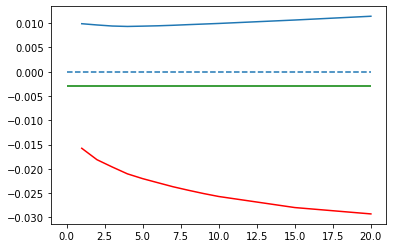

In [24]:
plt.hlines(metricas_dot3,xmin,xmax, colors='g')

lists = sorted(metricas_movies3.items())
x, y = zip(*lists)
plt.plot(x, y)

lists = sorted(metricas_users3.items())
x, y = zip(*lists)
plt.plot(x, y, color='r')
plt.hlines(0,xmin,xmax,linestyles='dashed')
plt.show()

In [25]:
df_val.head()

,movie_id,user_id,rating,movie_id_orig,user_id_orig,prediction_dot,prediction_movies_1,prediction_users_1,prediction_movies_2,prediction_users_2,...,prediction_movies_8,prediction_users_8,prediction_movies_9,prediction_users_9,prediction_movies_10,prediction_users_10,prediction_movies_15,prediction_users_15,prediction_movies_20,prediction_users_20
0,5944,17288,5,752,1551333,3.219725,5.0,4.0,4.658198,4.000000,...,4.133301,4.234404,4.123722,4.312770,3.982406,4.283999,3.972226,4.382281,3.801573,4.337996
1,2193,31509,4,14961,2009898,4.041693,4.0,3.0,4.296143,3.957549,...,3.835116,4.333648,3.720618,4.401748,3.736913,4.364951,3.580949,4.437167,3.516914,4.517931
2,4673,21434,5,4577,168479,3.287347,3.0,4.0,2.559936,4.449374,...,2.541733,4.146847,2.675858,4.229663,2.702684,4.121066,2.623475,4.085924,2.771850,3.758636
3,6554,28375,4,8846,1908261,3.757984,4.0,2.0,3.510932,2.499240,...,3.735730,3.345945,3.758869,3.207021,3.777670,3.187892,3.730789,3.375195,3.699932,3.336497
4,6937,63695,3,9757,659928,4.131509,5.0,5.0,4.596376,4.516640,...,4.425451,4.171205,4.119649,4.059098,4.110071,3.966646,4.027554,3.857383,4.096203,3.844289


In [47]:
%%time
df_val_aux = df_val.drop(['prediction_movies','prediction_users'],axis=1)
df_val_aux.head()

Wall time: 6.41 s


,movie_id,user_id,rating,movie_id_orig,user_id_orig,prediction_dot,prediction_movies_1,prediction_users_1,prediction_movies_2,prediction_users_2,...,prediction_movies_8,prediction_users_8,prediction_movies_9,prediction_users_9,prediction_movies_10,prediction_users_10,prediction_movies_15,prediction_users_15,prediction_movies_20,prediction_users_20
0,5944,17288,5,752,1551333,3.219725,5.0,4.0,4.658198,4.000000,...,4.133301,4.234404,4.123722,4.312770,3.982406,4.283999,3.972226,4.382281,3.801573,4.337996
1,2193,31509,4,14961,2009898,4.041693,4.0,3.0,4.296143,3.957549,...,3.835116,4.333648,3.720618,4.401748,3.736913,4.364951,3.580949,4.437167,3.516914,4.517931
2,4673,21434,5,4577,168479,3.287347,3.0,4.0,2.559936,4.449374,...,2.541733,4.146847,2.675858,4.229663,2.702684,4.121066,2.623475,4.085924,2.771850,3.758636
3,6554,28375,4,8846,1908261,3.757984,4.0,2.0,3.510932,2.499240,...,3.735730,3.345945,3.758869,3.207021,3.777670,3.187892,3.730789,3.375195,3.699932,3.336497
4,6937,63695,3,9757,659928,4.131509,5.0,5.0,4.596376,4.516640,...,4.425451,4.171205,4.119649,4.059098,4.110071,3.966646,4.027554,3.857383,4.096203,3.844289


In [49]:
%%time
#df_val_aux.to_parquet('../data/df_val_punt.zip',compression='gzip')

Wall time: 1min 20s


In [2]:
%%time
df_val = pd.read_parquet('../data/df_val_punt.zip')

Wall time: 9.85 s


In [3]:
df_val.head()

,movie_id,user_id,rating,movie_id_orig,user_id_orig,prediction_dot,prediction_movies_1,prediction_users_1,prediction_movies_2,prediction_users_2,...,prediction_movies_8,prediction_users_8,prediction_movies_9,prediction_users_9,prediction_movies_10,prediction_users_10,prediction_movies_15,prediction_users_15,prediction_movies_20,prediction_users_20
0,5944,17288,5,752,1551333,3.219725,5.0,4.0,4.658198,4.000000,...,4.133301,4.234404,4.123722,4.312770,3.982406,4.283999,3.972226,4.382281,3.801573,4.337996
1,2193,31509,4,14961,2009898,4.041693,4.0,3.0,4.296143,3.957549,...,3.835116,4.333648,3.720618,4.401748,3.736913,4.364951,3.580949,4.437167,3.516914,4.517931
2,4673,21434,5,4577,168479,3.287347,3.0,4.0,2.559936,4.449374,...,2.541733,4.146847,2.675858,4.229663,2.702684,4.121066,2.623475,4.085924,2.771850,3.758636
3,6554,28375,4,8846,1908261,3.757984,4.0,2.0,3.510932,2.499240,...,3.735730,3.345945,3.758869,3.207021,3.777670,3.187892,3.730789,3.375195,3.699932,3.336497
4,6937,63695,3,9757,659928,4.131509,5.0,5.0,4.596376,4.516640,...,4.425451,4.171205,4.119649,4.059098,4.110071,3.966646,4.027554,3.857383,4.096203,3.844289


In [4]:
df_val.shape

(6417714, 30)